# AllLife Bank Customer Segmentation
by Michele Casalgrandi

## Context
Based on feedback from their marketing research team, AllLife Bank wants to increase market penetration for their credit card offerings, including upselling to current customers.

Furthermore, market research found that customer support services are rated poorly and the bank intends to improve the support services to reduce time to resolution of customer queries.

## Objective
Identify customer segments based on speding patterns and past interations using clustering.

Provide recommendations to the bank on how to better market their products and improve customer support.

### Data Dictionary
* _Sl_No_: Primary key of the records
* _Customer Key_: Customer identification number
* _Average Credit Limit_: Average credit limit of each customer for all credit cards
* _Total credit cards_: Total number of credit cards possessed by the customer
* _Total visits bank_: Total number of visits that customer made (yearly) personally to the bank
* _Total visits online_: Total number of visits or online logins made by the customer (yearly)
* _Total calls made_: Total number of calls made by the customer to the bank or its customer service department (yearly)


## Exploratory Data Analysis

Import needed libraries

In [505]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# preprocessing and clustering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

# to compute cophenetic correlation, and create dendrograms
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to compute distances
from scipy.spatial.distance import pdist

# compute clustering scores
from sklearn.metrics import silhouette_score

# visualize clustering scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

Load data

In [506]:
df = pd.read_excel("Credit Card Customer Data.xlsx", sheet_name='Sheet1')

print(f'Data set has {df.shape[0]} rows and {df.shape[1]} columns')

Data set has 660 rows and 7 columns


In [507]:
# output the column names
df.columns

Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [508]:
# Check for data types
df.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

All columns are numerical.

In [509]:
df.sample(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
149,150,23768,14000,2,1,2,7
131,132,61627,9000,3,0,2,5
264,265,24808,17000,4,4,1,2
151,152,85707,19000,1,1,4,4
134,135,31256,13000,4,1,5,7
204,205,33317,17000,2,2,5,5
289,290,75775,7000,6,5,2,2
377,378,61994,19000,5,2,0,4
159,160,63751,8000,1,2,2,4
73,74,18821,19000,3,1,3,6


Check for uniqueness of `Sl_no` and `Customer Key`

In [510]:
# check unique 'Sl_No'
df['Sl_No'].nunique()

660

There are no duplicates for `Sl_No`.

We will drop the column as it doesn't provide any information for clustering

In [511]:
# make a copy and drop Sl_No
bank_df = df.copy()
bank_df = bank_df.drop("Sl_No", axis=1)

In [512]:
# check unique 'Customer Key'
df['Customer Key'].nunique()

655

In [513]:
# check for duplicated rows
df.duplicated().sum()

0

`Customer Key` is not unique for all records.  However, there are no duplicate rows.

In [514]:
dup_customer_key = df['Customer Key'][df['Customer Key'].duplicated()].to_list()
print("Duplicated 'Customer Key'", dup_customer_key)
df[df['Customer Key'].isin(dup_customer_key)].sort_values(by='Customer Key')

Duplicated 'Customer Key' [47437, 96929, 37252, 50706, 97935]


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


We can consider these rows with the same `Customer Key` as different snapshots in time of the same customers.

We will drop `Customer Key` and retain all the other columns.

In [515]:
# drop 'Customer Key' column
bank_df = bank_df.drop('Customer Key', axis=1)

In [516]:
# Check for missing values
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


There are no missing values.

### Univariate EDA

Display statistics for each column.

In [517]:
# set numerical format for pandas
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# get numerical data statistics
bank_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.000,34574.242,37625.488,3000.000,10000.000,18000.000,48000.000,200000.000
Total_Credit_Cards,660.000,4.706,2.168,1.000,3.000,5.000,6.000,10.000
Total_visits_bank,660.000,2.403,1.632,0.000,1.000,2.000,4.000,5.000
Total_visits_online,660.000,2.606,2.936,0.000,1.000,2.000,4.000,15.000
Total_calls_made,660.000,3.583,2.865,0.000,1.000,3.000,5.000,10.000


#### Observations
* `Avg_Credit_Limit` has a mean of 35K and a standard deviation of 38K.  The range is high at 197K
* `Total_Credit_Cards` have a mean of 4.7 and std deviation of 2.2.  It ranges from 3 to 10.
* `Total_visits_bank` ranges from 0 (no visits) to 5.  The average is 2.4.
* `Total_visits_online` ranges from 0 to 15.  The average is 2.6.
* `Total_calls_made` ranges from 0 to 10 with an average of 3.6.

##### Distributions

In [518]:
# define function to plot boxplots and histograms

# function takes a numerical column as the input and returns the boxplots 
# and histograms for the variable.
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(x=feature, kde=False, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

##### Avg_Credit_Limit

In [519]:
# TODO remove prior to submission
# get_ipython().set_next_input('histogram_boxplot(df["Customer_Age"])')

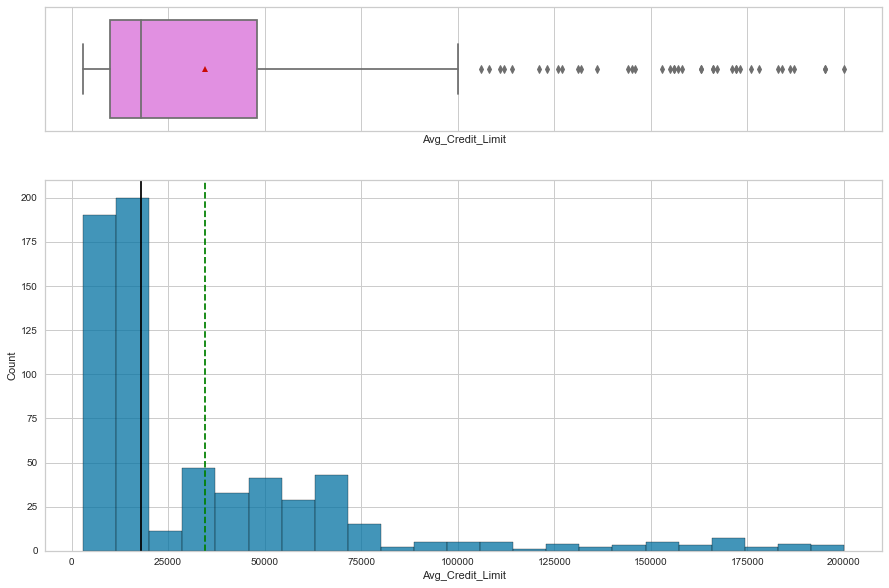

In [520]:
histogram_boxplot(df["Avg_Credit_Limit"])

`Avg_Credit_limit` is skewed to the right with a number of outliers.  The median is at 18000.

As outliers might be representing different customer segments we will not remove outliers.

##### Total_Credit_Cards

In [521]:
df["Total_Credit_Cards"].value_counts()

4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: Total_Credit_Cards, dtype: int64

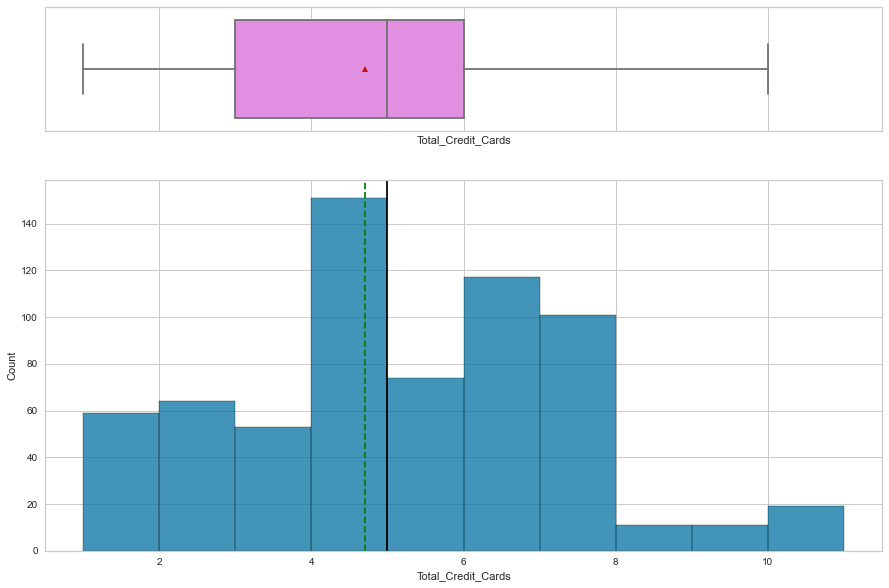

In [522]:
histogram_boxplot(df["Total_Credit_Cards"], bins=range(1, 12))

`Total_Credit_Cards` distribution if roughly centered with an IQR between 3 and 6.  No outliers.

##### Total_visits_bank

In [523]:
df["Total_visits_bank"].value_counts()

2    158
1    112
3    100
0    100
5     98
4     92
Name: Total_visits_bank, dtype: int64

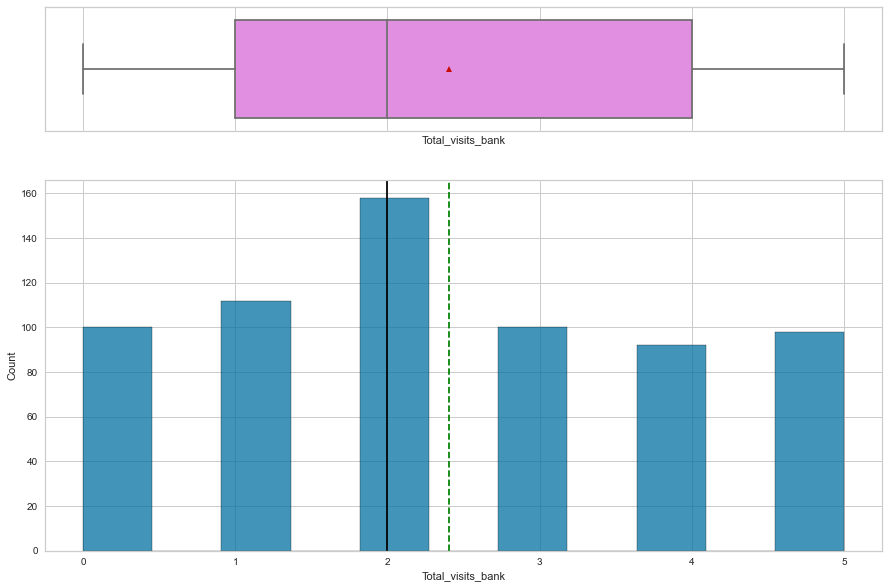

In [524]:
histogram_boxplot(df["Total_visits_bank"])

`Total_visits_bank` is almost uniformly distributed with the exception of a peak at 2.  No outliers.

##### Total_visits_online

In [525]:
df["Total_visits_online"].value_counts()

2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
12      6
10      6
8       6
13      5
11      5
9       4
14      1
6       1
Name: Total_visits_online, dtype: int64

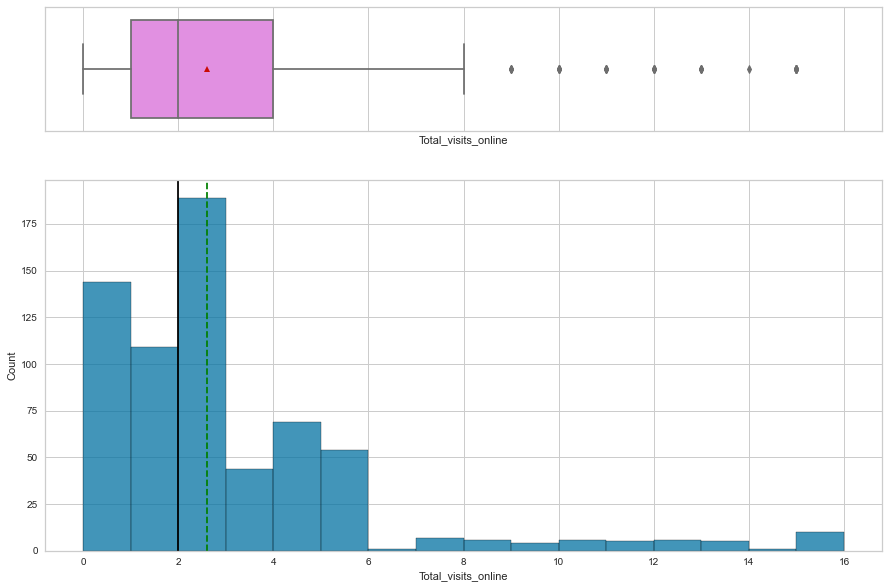

In [526]:
histogram_boxplot(df["Total_visits_online"], bins=range(0,17))

`Total_visits_online` is skewed to the right with most customers with 2 visits or less. Many outliers.

As outliers might be representative of customer segments we will not treat outliers.

##### Total_calls_made

In [527]:
df["Total_calls_made"].value_counts()

4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64

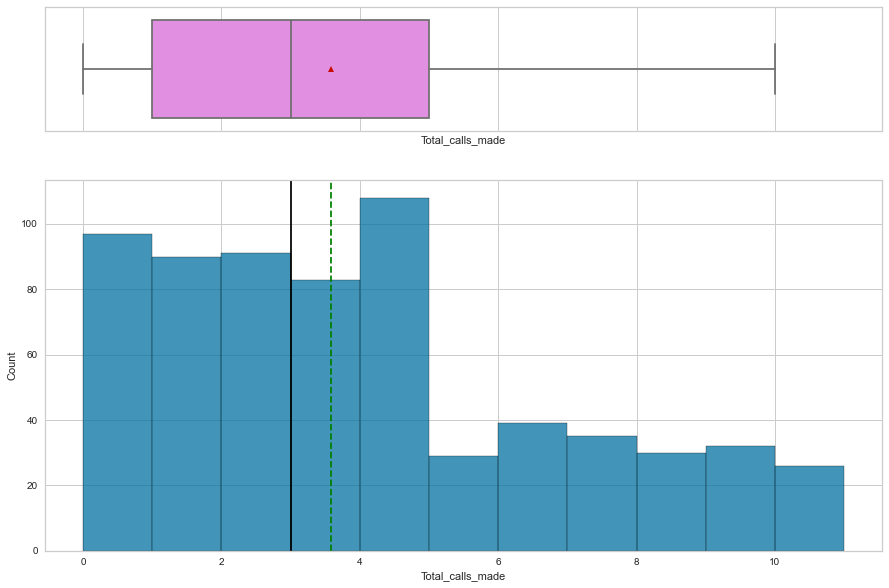

In [528]:
histogram_boxplot(df["Total_calls_made"], bins=range(0,12))

`Total_calls_made` is skewed to the right with most customers with 4 calls or less. There are no outliers.

### By-variate analysis

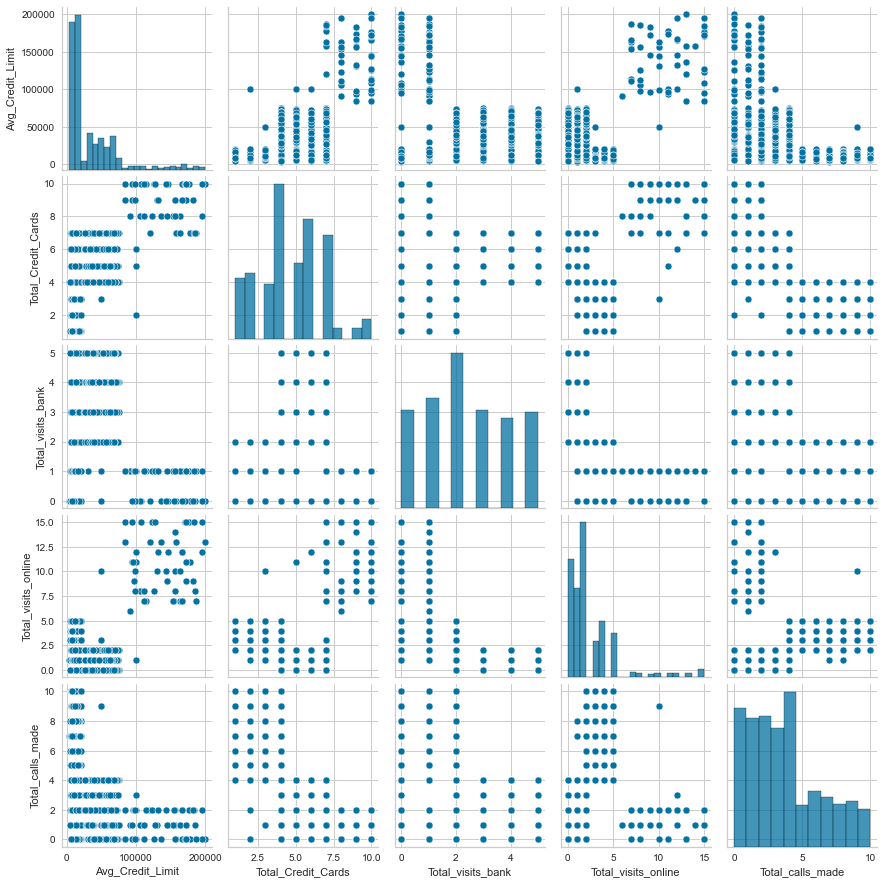

In [529]:
# plot pairs
sns.pairplot(bank_df)

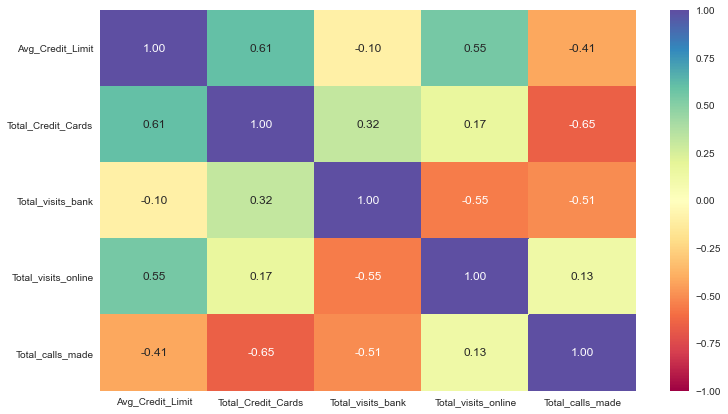

In [530]:
# plot correlation matrix
plt.figure(figsize=(12, 7))
sns.heatmap(
    bank_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

#### Observations
* `Avg_Credit_Limit` and `Total_Credit_Cards` appear linearly related, which is expected as the higher the number of cards, the higher the total credit limit will be
* `Total_call_made` and `Total_visits_online` appear to be negatively correlated.  Customers who use online access might not need to call the bank as much to get the information needed or issues resolved
* `Total_visits_online` appear higher for customers with a higher `Avg_credit_limit`
* `Total_calls_made` is _lower_ for customer with higher number of `Total_Credit_Cards`
* Similarly the `Total_calls_made` is lower as the `Avg_Credit_Limit` increases

##### "Avg_Credit_Limit" vs "Total_Credit_Cards"

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='Avg_Credit_Limit'>

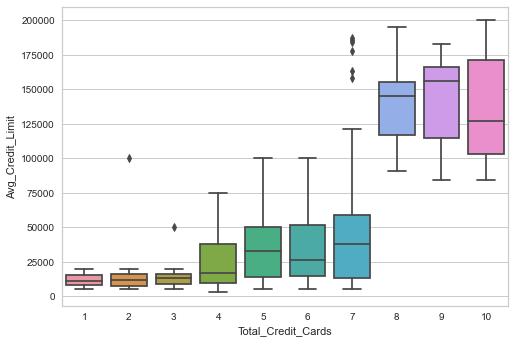

In [531]:
sns.boxplot(y=bank_df["Avg_Credit_Limit"], x=bank_df["Total_Credit_Cards"])

There seem to be roughly three separate groups with Total_Credit_Cards ranges: 1 to 3, 4 to 7 and 8 to 10.  The third group has significantly higher Avg_Credit_Limit.

##### "Avg_Credit_Limit" vs "Total_visits_bank"

<AxesSubplot:xlabel='Total_visits_bank', ylabel='Avg_Credit_Limit'>

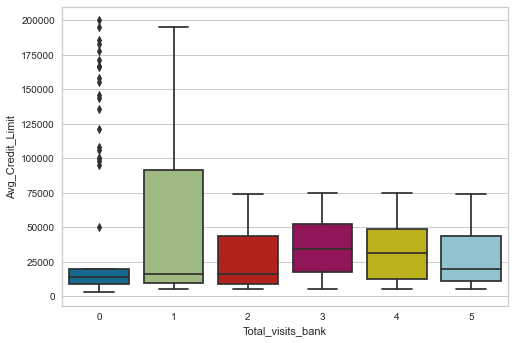

In [532]:
sns.boxplot(y=bank_df["Avg_Credit_Limit"], x=bank_df["Total_visits_bank"])

There could be two or three group depending on the criteria.  Customers with 0 or 1 for Total_visits_bank have much higher range for Avg_Credit_Limit

##### "Avg_Credit_Limit" vs "Total_visits_online"

<AxesSubplot:xlabel='Total_visits_online', ylabel='Avg_Credit_Limit'>

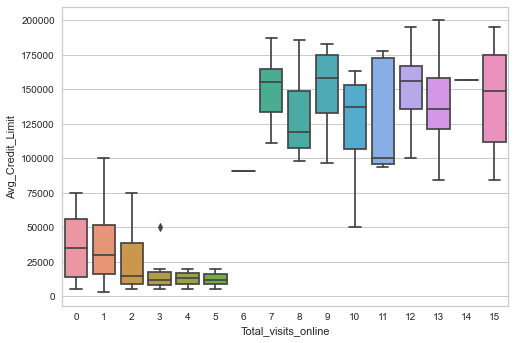

In [533]:
sns.boxplot(y=bank_df["Avg_Credit_Limit"], x=bank_df["Total_visits_online"])

There are two possible groups.  One with bank visits between 0 and 5, who have a lower credit limit. Another with visits online 7 or higher who have higher credit limit.

For 6 visits, there is only one observation, so it doesn't make sense to set that in a separate group.

##### "Avg_Credit_Limit" vs "Total_calls_made"

<AxesSubplot:xlabel='Total_calls_made', ylabel='Avg_Credit_Limit'>

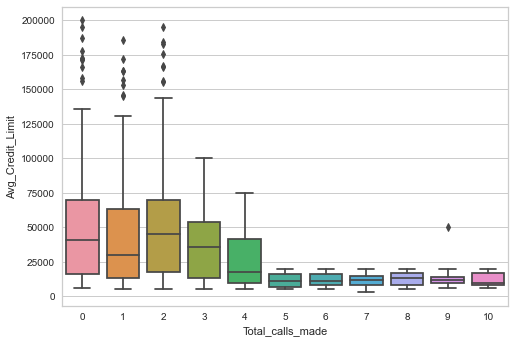

In [534]:
sns.boxplot(y=bank_df["Avg_Credit_Limit"], x=bank_df["Total_calls_made"])

There appear to be at least two groups.  Those with total calls less than 5, who have higher average credit limit and wider range.  The rest with 5 calls or above have lower credit limit and much smaller range and IQRs

##### "Total_Credit_Cards" vs "Total_visits_bank"

<AxesSubplot:xlabel='Total_visits_bank', ylabel='Total_Credit_Cards'>

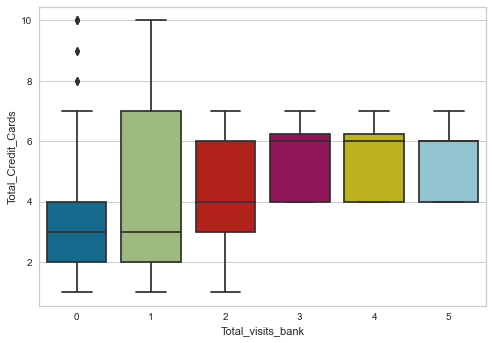

In [535]:
sns.boxplot(y=bank_df["Total_Credit_Cards"], x=bank_df["Total_visits_bank"])

Customers with 3 or more bank visits have higher number of credit cards on average, but also have smaller range and IQRs than those with 2 or less visits.

##### "Total_Credit_Cards" vs "Total_visits_online"

<AxesSubplot:xlabel='Total_visits_online', ylabel='Total_Credit_Cards'>

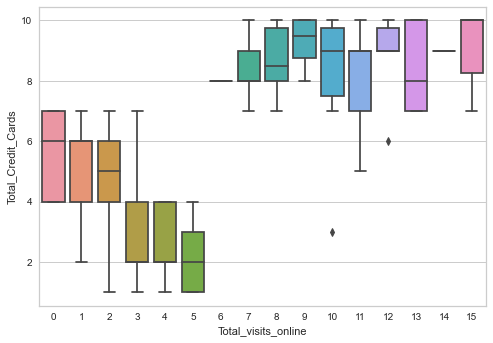

In [536]:
sns.boxplot(y=bank_df["Total_Credit_Cards"], x=bank_df["Total_visits_online"])

There is a net separation between customers with 7 or more online visits, who have much higher number of credit cards, versus the rest of the customers.

The customers with 5 or less online visits, could possibly separated in two groups with different average number of credit card (e.g. visits online between 3 and 5)

##### "Total_Credit_Cards" vs "Total_calls_made"

<AxesSubplot:xlabel='Total_calls_made', ylabel='Total_Credit_Cards'>

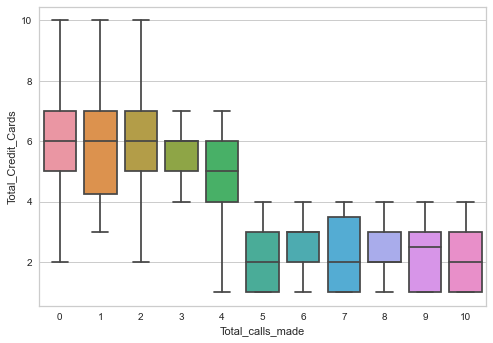

In [537]:
sns.boxplot(y=bank_df["Total_Credit_Cards"], x=bank_df["Total_calls_made"])

Two main groups can be observed, one with 5 or more calls made, who have lower average number of credits card (all 4 or less); the other for customers with 4 or less calls who have bigger ranges for the number of credit cards.

##### "Total_visits_bank" vs "Total_visits_online"

<AxesSubplot:xlabel='Total_visits_online', ylabel='Total_visits_bank'>

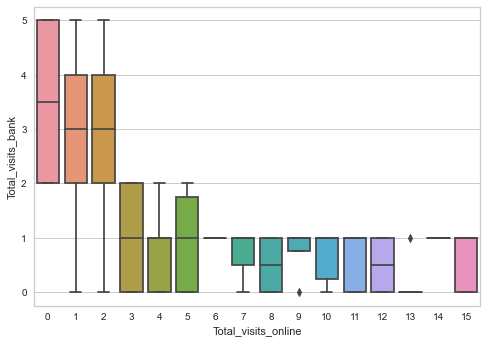

In [538]:
sns.boxplot(y=bank_df["Total_visits_bank"], x=bank_df["Total_visits_online"])

Three group could be identified: one with 2 or less online visits, who have a higher average bank visits. 
    
One with 3 to 5 online visits that have 2 or less bank visits.

The last with 7 or higher online visits, all of whom have 1 bank visit or less.

##### "Total_Credit_Cards" vs "Total_visits_online"

<AxesSubplot:xlabel='Total_visits_online', ylabel='Total_Credit_Cards'>

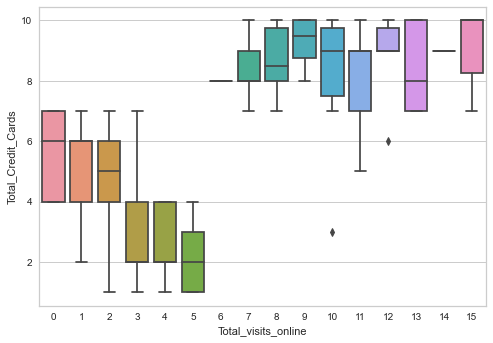

In [539]:
sns.boxplot(y=bank_df["Total_Credit_Cards"], x=bank_df["Total_visits_online"])

Two major groups can be identified.  The first with 7 or more online visits, who have a high number of credit cards.

The other with 5 or less online visits, who all have at most 7 cards and lower average number of credit cards.

6 online visits, consists of just one observation.

##### "Total_visits_bank" vs "Total_calls_made"

<AxesSubplot:xlabel='Total_calls_made', ylabel='Total_visits_bank'>

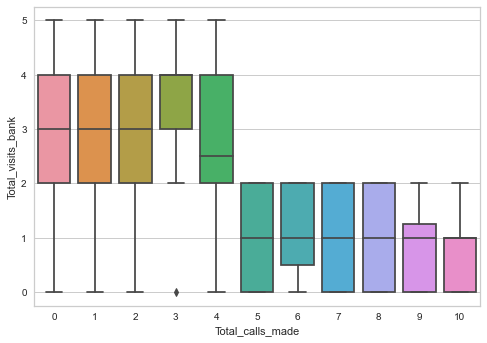

In [540]:
sns.boxplot(y=bank_df["Total_visits_bank"], x=bank_df["Total_calls_made"])

Two groups stand out.  One for customers with 4 calls or less, all of whom have higher average bank visits

The remaining with 5 or more calls, all have 2 or less bank visits and smaller range for number of visits.

##### "Total_visits_online" vs "Total_calls_made"

<AxesSubplot:xlabel='Total_calls_made', ylabel='Total_visits_online'>

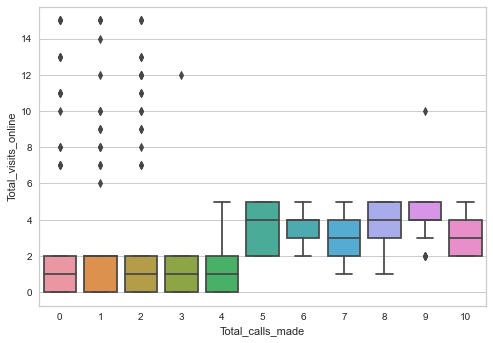

In [541]:
sns.boxplot(y=bank_df["Total_visits_online"], x=bank_df["Total_calls_made"])

Roughly two groups can be identifies.  One with customers with less than 4 calls made, who have lower average number of online visits but a number of outliers in the number of online visits.

The second group with 4 or more calls, who have 5 online visits or less.

## Models building

### Data preprocessing - scaling

In [542]:
# use standard scaler: zero mean, std dev = 1
scaler = StandardScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(bank_df),
    columns=bank_df.columns)

In [543]:
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.000,0.000,1.001,-0.840,-0.654,-0.441,0.357,4.400
Total_Credit_Cards,660.000,-0.000,1.001,-1.711,-0.788,0.136,0.597,2.444
Total_visits_bank,660.000,0.000,1.001,-1.474,-0.860,-0.247,0.979,1.593
Total_visits_online,660.000,0.000,1.001,-0.888,-0.547,-0.207,0.475,4.225
Total_calls_made,660.000,-0.000,1.001,-1.252,-0.902,-0.204,0.495,2.241


### Clustering: K-means

##### Model the date using KMeans clustering with various cluster sizes and evaluate performance using Silhouette score

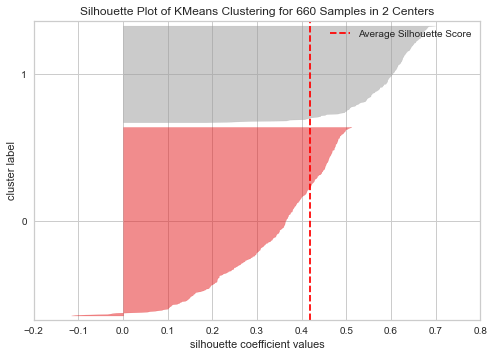

2 clusters: silhouette score = 0.41842496663215445



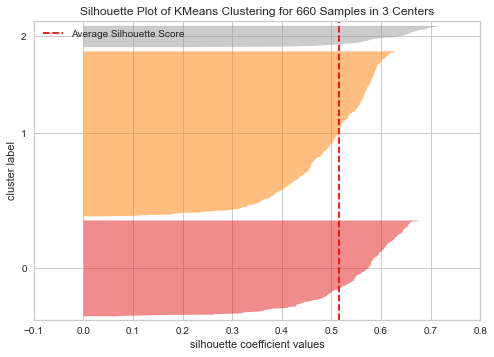

3 clusters: silhouette score = 0.5157182558881063



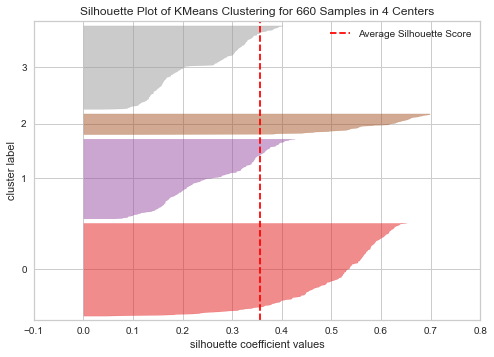

4 clusters: silhouette score = 0.3556670619372605



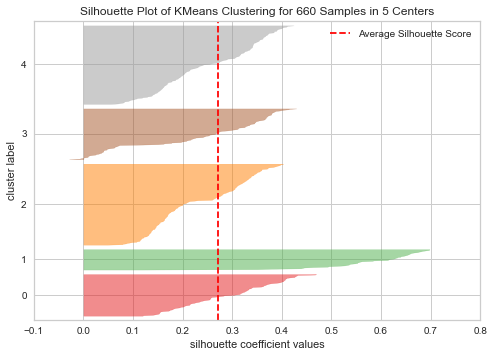

5 clusters: silhouette score = 0.2717470361089752



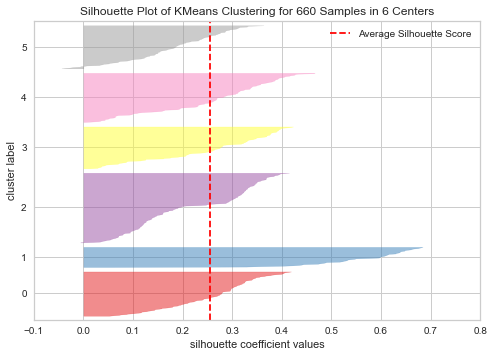

6 clusters: silhouette score = 0.255906765297388



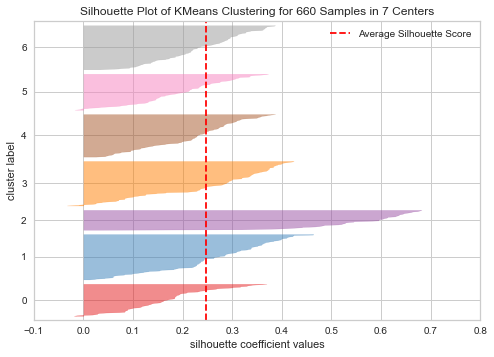

7 clusters: silhouette score = 0.24798644656011146



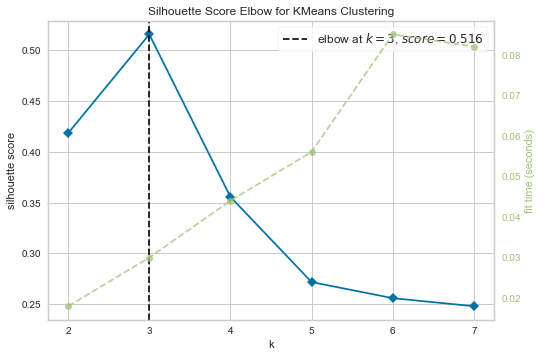

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [544]:
# array to hold silhouette scores
s_scores = []

num_clusters = range(2,8)

# build a k-means model for different numbers of clusters
for k in num_clusters:
    km_model = KMeans(n_clusters=k, random_state=1)
    
    s_visualizer = SilhouetteVisualizer(km_model)
    s_visualizer.fit(scaled_df)
    s_visualizer.show()

    s_scores.append(s_visualizer.silhouette_score_)
    print(f'{k} clusters: silhouette score = {s_visualizer.silhouette_score_}\n')

# # plot silhouette trend graph
# plt.plot(num_clusters, s_scores, "bx-")
# plt.xlabel("k")
# plt.ylabel("Silhouette score")
# plt.title("Silhouette score by number of clusters", fontsize=20)

# print silhouette trend graph
km_model = KMeans(random_state=1)
ke_visualizer = KElbowVisualizer(km_model, k=7, metric='silhouette', random_state=1)
ke_visualizer.fit(scaled_df)
ke_visualizer.show()

#### K-means model performance - silhouette score
The optimal number of clusters based on the silhoutte score is 3.

With 3 clusters, the silhouette score is 0.516, which is the highest than any other number of clusters up to 7.

Finer segmentation is achievable with higher number of clusters.

#### K-means model performance: distorsion score - Elbow method

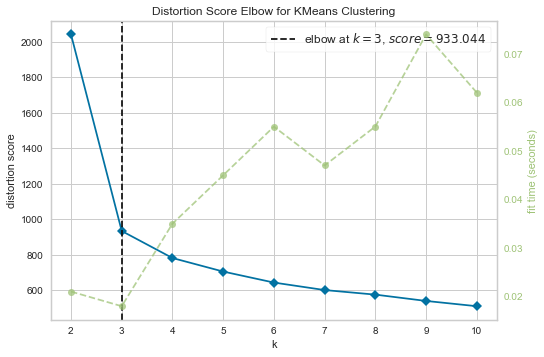

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [545]:
# use elbow visualizer with distorsion metric
km_model = KMeans(random_state=1)
ke_visualizer = KElbowVisualizer(km_model, k=10, metric='distortion', random_state=1)
ke_visualizer.fit(scaled_df)
ke_visualizer.show()

#### Cluster numbers
The optimal number of clusters based on distorsion score is 3.

We will use 3 as the optimal number of clusters for k-means.

In [546]:
# create a k-means model with k=3
optimal_k = 3
k_means = KMeans(n_clusters=optimal_k, random_state=1)

# fit the model
k_means.fit(scaled_df)

# extract the labels and add to original dataframe
km_segment_col = 'km_segment'
bank_df[km_segment_col] = k_means.labels_

In [547]:
bank_df.sample(5)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,km_segment
294,7000,6,5,2,3,1
547,26000,4,5,2,4,1
499,68000,6,4,2,2,1
316,18000,6,4,0,2,1
326,6000,4,4,2,3,1


Review statistics (mean) of each segment

In [548]:
# calculate means of each segment columns
k_means_segments_summary = bank_df.groupby(by=km_segment_col).mean()
k_means_segments_summary

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
km_segment,,,,,
0,12174.107,2.411,0.933,3.554,6.871
1,33782.383,5.516,3.490,0.982,2.000
2,141040.000,8.740,0.600,10.900,1.080


In [549]:
# add column with count of observations for each cluster
k_means_segments_summary['segment-count'] = bank_df.groupby(by=km_segment_col)['Total_calls_made'].count()
k_means_segments_summary

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,segment-count
km_segment,,,,,,
0,12174.107,2.411,0.933,3.554,6.871,224
1,33782.383,5.516,3.490,0.982,2.000,386
2,141040.000,8.740,0.600,10.900,1.080,50


* Segment 2 has the least number of observations (50) with the highest credit limit mean at 141000. Customers in this segment have the highest number of credit cards (10.9 on average).  
    Also they prefer to use online access to the bank.

* Segment 1 has 386 observations with an average credit limit of 33800.  
    Customers in this segment have 5.52 credit cards on average and prefer calling or visiting the bank in person
    
* Segment 0 has 224 observations with the lowest average credit limit of 12200.  Customers in this segment have the lowest number of credit card at 2.41  
    Customers in this segment have low number of visits and tend to prefer calling and online access.

##### Plot features distributions by cluster

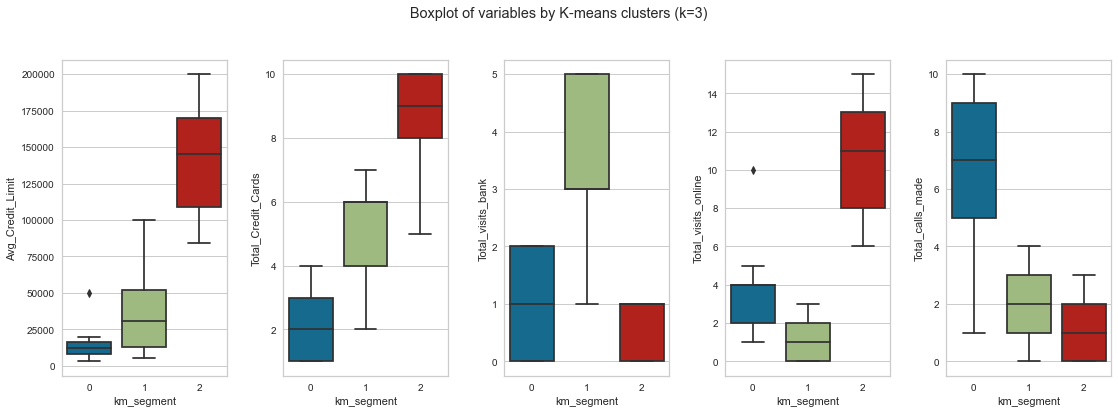

In [550]:
# get columns to be displayed
cols = bank_df.columns.drop(km_segment_col)

# get plot instance
fig, axes = plt.subplots(1, len(cols), figsize=(16, 6))

fig.suptitle(f"Boxplot of variables by K-means clusters (k={optimal_k})")

# add boxplot for each variable by segment
for col_num in range(len(cols)):
    sns.boxplot(ax=axes[col_num], y=bank_df[cols[col_num]], x=bank_df[km_segment_col])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='km_segment'>

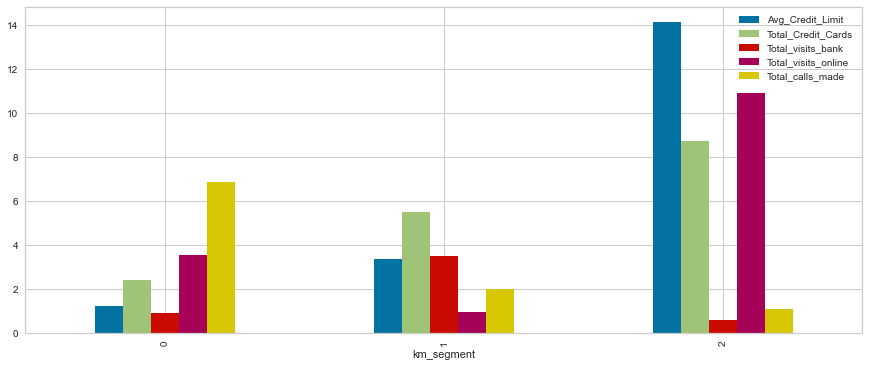

In [551]:
# scale credit limit for plotting against variables with much smaller range
plot_df = bank_df.copy()
plot_df['Avg_Credit_Limit'] = plot_df['Avg_Credit_Limit'] / 10000

plot_df.groupby(km_segment_col).mean().plot.bar(figsize=(15, 6))

#### Observations
* Segment 2:
    * Very high avg credit limit : 140000 
    * High number of credit cards
    * Preferred method of access to the bank is online
    * Very low number of visits to the bank
    * Very low number of calls to the bank
    * Smallest segment with 50 customers
* Segment 1
    * Largest segment with 386 observations
    * Credit limit average is 34K
    * A moderate number of credit cards (avg 5.5)
    * The highest number of visits to the bank of all the segments
    * Low number of online visits 
    * Low number of calls but higher than segment 0
* Segment 0
    * Second largest segment with 224 observations
    * The lowest average credit limit at 12200
    * The lowest number of credit cards (2.4)
    * Low number of bank visits
    * Moderate avg number of online visits (3.5)
    * The highest number of calls to the bank

### Clustering: hierarchical

Use agglomerative hierarchical clustering with different linkages and plot their dendrograms

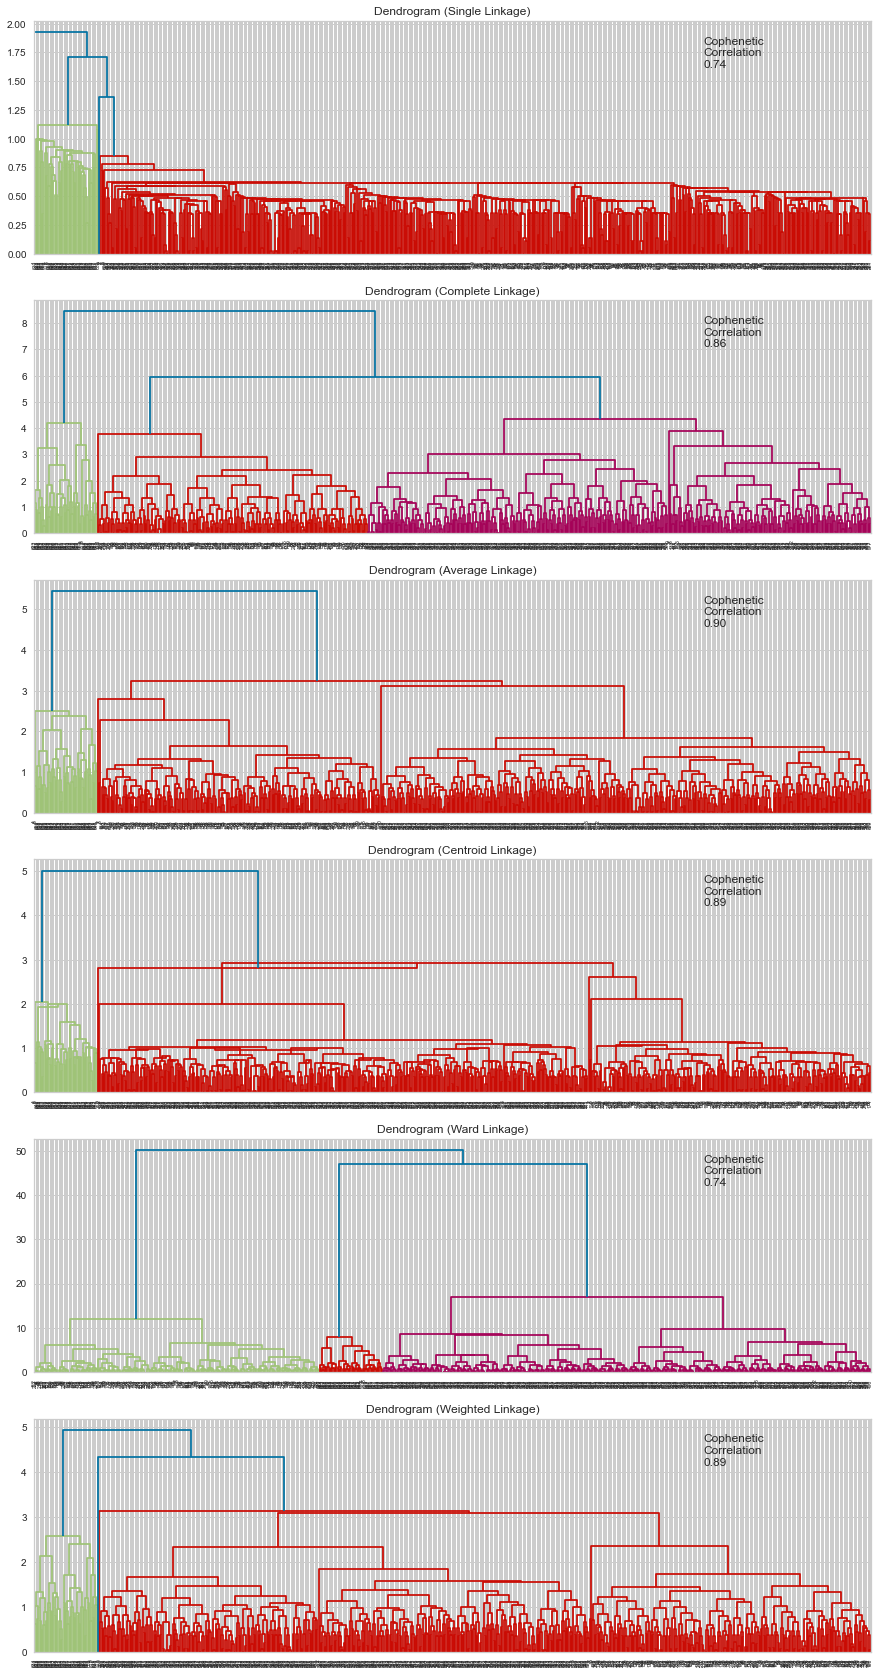

In [552]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

* The highest cophenetic correlation is achieved with 'Average' linkage (0.90).
* From the 'Average' linkage dendrogram we choose three as the optimal number of clusters.  Less clusters does not provide enough granularity.  More clusters would result in clusters with very low customer count which are not big enough to be significant.

##### Build agglomerative clustering model

In [553]:
# train agglomerative clustering model with 3 clusters
hc_optimal_k = 3

aggl_model = AgglomerativeClustering(n_clusters=hc_optimal_k, affinity='euclidean', linkage='average')
aggl_model.fit(scaled_df)

# add labels from hierarchical clustering to original dataframe
hc_segment_column = 'hc_segment'
bank_df[hc_segment_column] = aggl_model.labels_



In [554]:
# compute silhouette score
hc_silh_score = silhouette_score(scaled_df, aggl_model.labels_, metric='euclidean')
print('Hierarchical silhouette score with', hc_optimal_k, 'clusters:', hc_silh_score)

Hierarchical silhouette score with 3 clusters: 0.515922432650965


#### Cluster profiling
##### Hierarchical segments statistics

In [555]:
bank_df.head(5)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,km_segment,hc_segment
0,100000,2,1,1,0,1,0
1,50000,3,0,10,9,0,2
2,50000,7,1,3,4,1,0
3,30000,5,1,1,4,1,0
4,100000,6,0,12,3,2,1


In [556]:
# calculate means of each segment columns
hc_df = bank_df.copy().drop(km_segment_col, axis=1)
hc_segments_summary = hc_df.groupby(by=hc_segment_column).mean()
hc_segments_summary

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
hc_segment,,,,,
0,33713.178,5.512,3.486,0.984,2.005
1,141040.000,8.740,0.600,10.900,1.080
2,12197.309,2.404,0.928,3.561,6.883


In [557]:
# add column with count of observations for each cluster
hc_segments_summary['segment-count'] = hc_df.groupby(by=hc_segment_column)['Total_calls_made'].count()
hc_segments_summary

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,segment-count
hc_segment,,,,,,
0,33713.178,5.512,3.486,0.984,2.005,387
1,141040.000,8.740,0.600,10.900,1.080,50
2,12197.309,2.404,0.928,3.561,6.883,223


In [558]:
# check for how many records are not in the same segment across models
print(bank_df[km_segment_col][(bank_df[hc_segment_column] == 0) & (bank_df[km_segment_col] == 1)].count())
print(bank_df[km_segment_col][(bank_df[hc_segment_column] == 2) & (bank_df[km_segment_col] == 0)].count())
print(bank_df[km_segment_col][(bank_df[hc_segment_column] == 1) & (bank_df[km_segment_col] == 2)].count())

386
223
50


* Segments are almost identical to those obtained from k-means except for the numbering.  
    Only one observation is classified differently by the two models.
* Count for the smallest segment is composed of 50 customers as it is for k-means.  These are customers with high average credit limit.
* The largest segment is composed of 387 customers with a average moderate credit limit and moderate number of credit cards.
* The last segment with 223 customers is composed of customers with the lowest average credit limit

##### Barplots by agglomerative cluster (segment)

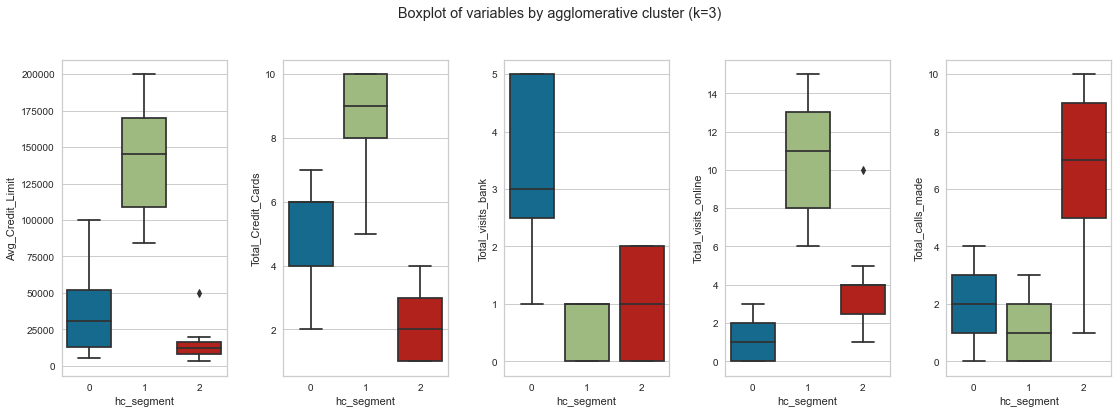

In [559]:
# get plot instance
fig, axes = plt.subplots(1, len(cols), figsize=(16, 6))

fig.suptitle(f"Boxplot of variables by agglomerative cluster (k={hc_optimal_k})")

# add boxplot for each variable by segment
for col_num in range(len(cols)):
    sns.boxplot(ax=axes[col_num], y=bank_df[cols[col_num]], x=bank_df[hc_segment_column])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='hc_segment'>

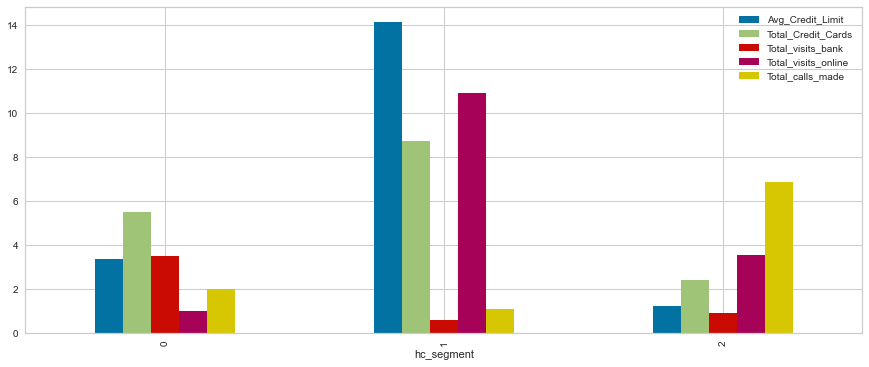

In [560]:
# scale credit limit for plotting against variables with much smaller range
plot_df = bank_df.copy().drop([km_segment_col], axis=1)
plot_df['Avg_Credit_Limit'] = plot_df['Avg_Credit_Limit'] / 10000

plot_df.groupby(hc_segment_column).mean().plot.bar(figsize=(15, 6))

#### Observations

* The segments identified by the hierarchical clustering are basically the same as k-means and the plots are indistinguishable from each other (except for the numbering of the cluster).
* The same observations made in KMeans profiling apply to hierarchical clustering model used here.

#### Clusters comparison - Hierachical vs KMeans

* k-means and hierarchical clustering resulted in basically identical clusters
* Time to execute the k-means model training is significantly better than hierarchical modeling and is noticeable even on a small dataset
* Silhouette score for 3 clusters is 0.5159 for hierarchical and 0.5157 for k-means, practically identical.
* The two models produce the same results.
* KMeans is preferable as it uses less resources and is faster

In [561]:
# calculate cumulative (sum) for each segment
hc_df = bank_df.copy().drop(km_segment_col, axis=1)
hc_segments_summary = hc_df.groupby(by=hc_segment_column).sum()
hc_segments_summary['segment-count'] = hc_df.groupby(by=hc_segment_column)['Total_calls_made'].count()
hc_segments_summary

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,segment-count
hc_segment,,,,,,
0,13047000,2133,1349,381,776,387
1,7052000,437,30,545,54,50
2,2720000,536,207,794,1535,223


### Insights and Recommendations
* Modeling using both KMeans and Hierachical clustering were performed
* The optimal number of cluster is three for both methods
* Scores of the two models with three clusters are the same and segmented customer in the same groups
* Profiling of customer segments shows:
    * Segment A:
        * 50 customers (7.6% of observations)
        * High average credit limit of 141K
        * High number of credit cards (segment avg 8.7)
        * Low numbers of bank visits and calls made
        * High number of online visits (10.9)
    * Segment B 
        * 386 customers (58% of observations)
        * Average credit limit close to the mean of the entire data set (33K)
        * A moderate number of credit cards (avg 5.5)
        * The highest number of visits to the bank of all the segments
        * Low number of online visits 
        * Low number of calls
    * Segment C
        * 224 customers (34% of observations)
        * The lowest average credit limit at 12200
        * The lowest number of credit cards (2.4)
        * Low number of bank visits
        * Moderate avg number of online visits (3.5)
        * The highest number of calls to the bank

#### Recommendations
* Customers with the highest credit limit (segment A) use online access more than any other methods
    * Online services should beenhanced to increase satisfaction rates for these customers with the highest spending potential
* The highest cumulative number of online visits is 794 for customers in segment C
    * Online presence should be the area with the most investment to increase satisfaction rates for  customers with highest cumulative online usage (segment C)
* The highest cumulative number of bank visits is from segment B.
    * A campaign should aim to convert these customers to use online services and self-serve instead of in-person services:
        * faster customer service as it is easier to scale up online services than personnell at the bank
        * reduce or eliminated wait time for services and therefore raise customer satisfaction
    * Online services should be enhanced to reduce or eliminate services that currently can be done only in person
* Target customers online for credit card services offering as they are the highest spenders
* Extend data collection to include additional features in order to better understand the profile of each customer segment and allow for possibly finer segmentation (more than 3 clusters)